In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets
import glob

from connectivity import constants as const
from connectivity import visualize as vis
from connectivity import nib_utils as nio

%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/maedbhking/.local/share/virtualenvs/cerebellum_connectivity-DbxULmID/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [16]:
# initialize directories and load train and eval dataframes
dirs = const.Dirs()

vis.plotting_style()


df_train = vis.train_summary(summary_name="train_summary",
                            exps=['sc1'], 
                            models_to_exclude=['NNLS', 'PLSRegress'])

# df_eval = vis.eval_summary(summary_name="eval_summary",
#                            exps=['sc2'], 
#                            models_to_exclude=['NNLS', 'PLSRegress'])

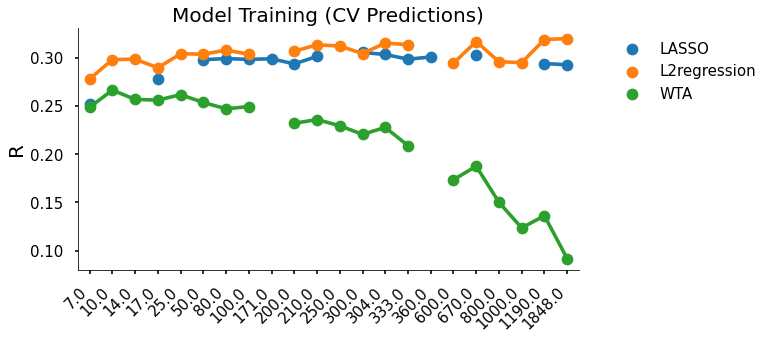

<Figure size 921.6x633.6 with 0 Axes>

In [18]:
# plot alpha curve for train CVs
# WTA

vis.plot_train_predictions(dataframe=df_train,
                           x='train_num_regions', 
                           methods=['LASSO', 'WTA', 'L2regression'], 
                           best_models=True,
                           hue='train_model'); 


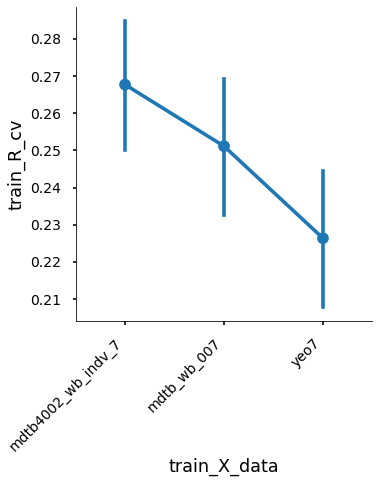

In [104]:
# Individual versus group parcellation (7-regions)

df_filter = df_train[df_train['train_X_data']\
                     .isin(['yeo7', 'mdtb_wb_007', 'mdtb4002_wb_indv_7'])]

df_filter = df_filter[df_filter['train_model'].isin(['L2regression'])]

sns.factorplot(x='train_X_data', 
               y="train_R_cv",  
               data=df_filter)
plt.xticks(rotation='45', ha='right');

No handles with labels found to put in legend.


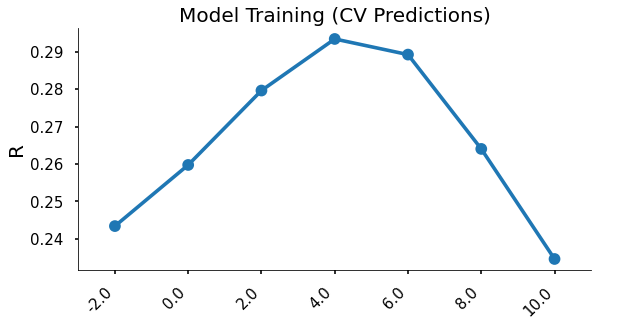

No handles with labels found to put in legend.


<Figure size 921.6x633.6 with 0 Axes>

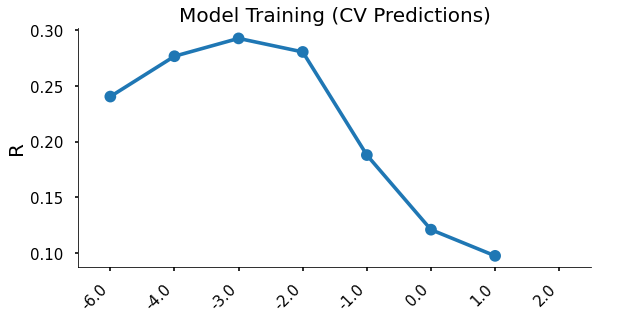

<Figure size 921.6x633.6 with 0 Axes>

In [49]:
# RIDGE
vis.plot_train_predictions(dataframe=df_train, 
                           x='train_hyperparameter',  
                           methods=['L2regression'],
                           best_models=False);

# LASSO
vis.plot_train_predictions(dataframe=df_train, 
                           x='train_hyperparameter',  
                           methods=['LASSO'],
                           best_models=False);


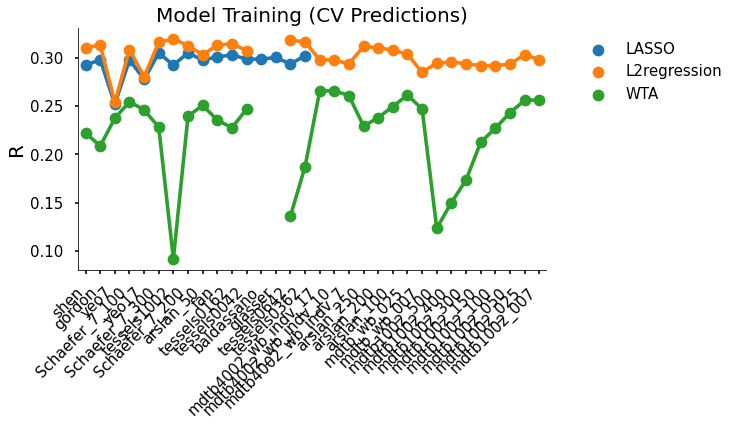

<Figure size 921.6x633.6 with 0 Axes>

In [20]:
# compare methods (cv)

vis.plot_train_predictions(dataframe=df_train,
                           x='train_X_data', 
                           hue='train_model', 
                           best_models=True,
                           methods=['L2regression', 'WTA', 'LASSO'])


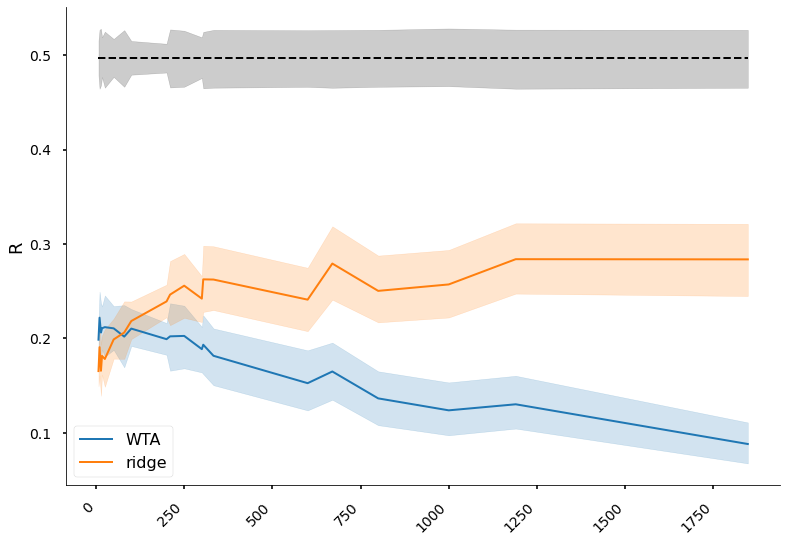

In [58]:
# Model evaluation - best models

vis.plot_eval_predictions(dataframe=df_eval,
                          hue='eval_model',
                          methods=['ridge', 'WTA'],
                          noiseceiling=True);

In [141]:
# Model evaluation (noise ceiling and predictions) - best model

#plot evaluation
# vis.plot_best_eval(exps=['sc1'])

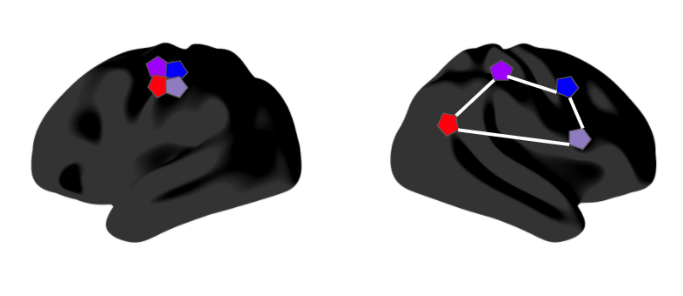

In [8]:
import matplotlib.image as mpimg

fname = os.path.join(dirs.figure, 'sparsity.png')

fig = plt.figure(figsize=(12,12))
img = mpimg.imread(fname)
plt.imshow(img)
plt.axis('off')
plt.show()

In [182]:
@widgets.interact(roi=['yeo7', 'yeo17', 'mdtb1002_007'])

def distance_matrix(roi):
    vis.show_distance_matrix(roi)

interactive(children=(Dropdown(description='roi', options=('yeo7', 'yeo17', 'mdtb1002_007'), value='yeo7'), Ou…

In [ ]:
###### visualize model weights - cerebellum or cortex

exp = 'sc1'

model, _ = vis.get_best_models(train_exp=exp)
model.insert(0,'best_model')

# get atlases
_, atlases = nio.get_cerebellar_atlases()

@widgets.interact(structure=['cerebellum', 'cortex'],
                 model_name=model,
                 hemisphere=[None, 'R', 'L'], 
                 colorbar=[True, False],
                 roi_summary=[True, False],
                 atlas=atlases)

def map_weights(structure, model_name, hemisphere, colorbar, roi_summary, atlas):
    view = vis.map_weights(structure, exp, model_name, hemisphere, rois=roi_summary, atlas=atlas)

interactive(children=(Dropdown(description='data', options=('R', 'R2', 'noiseceiling_XY_R', 'noiseceiling_Y_R'…

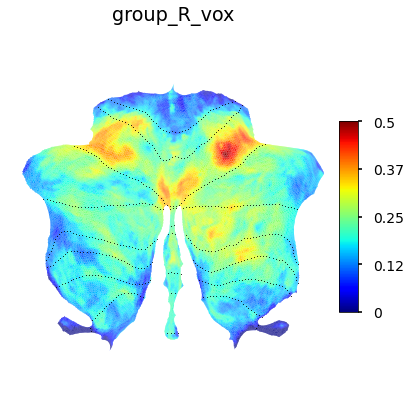

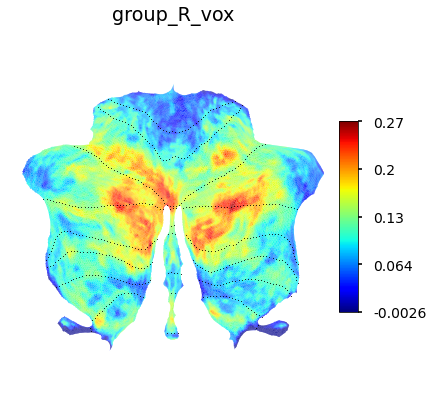

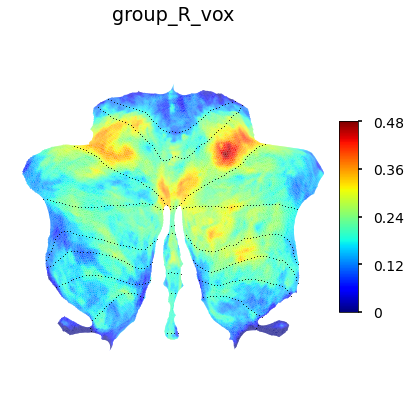

In [6]:
# visualize model evaluations

exp = 'sc1'

model, _ = vis.get_eval_models(exp=exp)
model.insert(0,'best_model')

# get atlases
_, atlases = nio.get_cerebellar_atlases()

@widgets.interact(data=['R','R2',
                        'noiseceiling_XY_R',
                        'noiseceiling_Y_R'],
                 model_name=model,
                 colorbar=[True, False],
                 roi_summary=[False, True],
                 atlas=atlases)

def map_eval(data, model_name, colorbar, roi_summary, atlas):
    view = vis.map_eval(data, exp, model_name, colorbar, rois=roi_summary, atlas=atlas)

interactive(children=(Dropdown(description='model_name', options=('Schaefer_7_100', 'Schaefer_7_200', 'Schaefe…

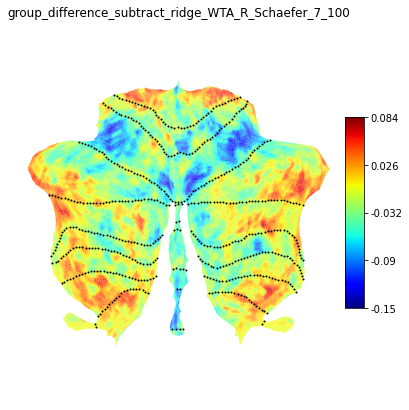

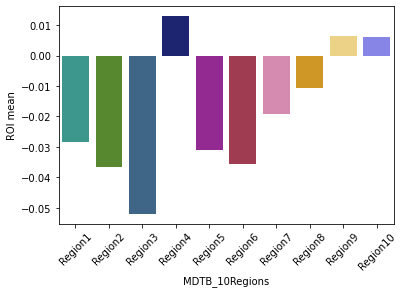

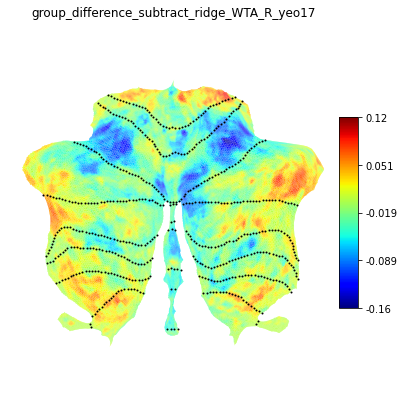

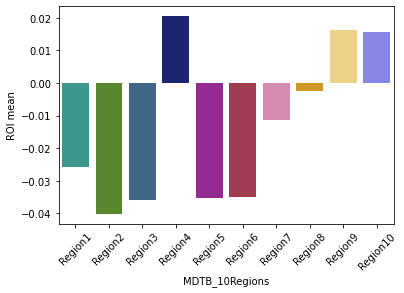

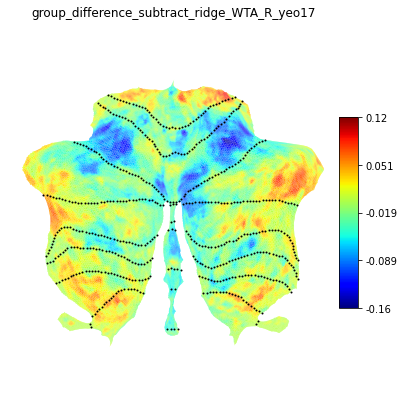

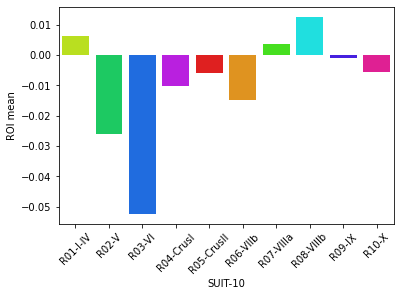

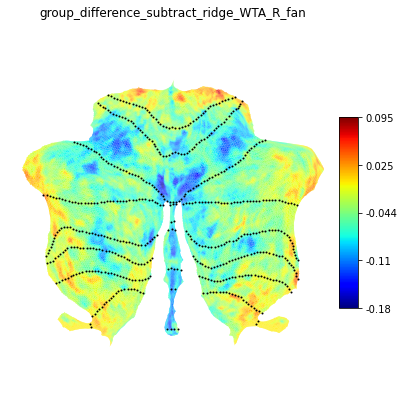

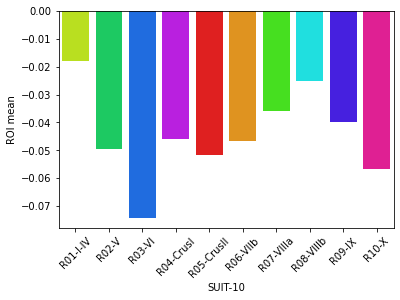

In [10]:
# visualize model comparisons (binary or subtract)

exp = 'sc1'

# get evaluated models
_, cortex_names = vis.get_eval_models(exp=exp)

# get atlases
_, atlases = nio.get_cerebellar_atlases()

@widgets.interact(model_name=cortex_names, 
                 method=['subtract', 'binarize'],
                 colorbar=[True, False],
                 roi_summary=[True, False],
                 atlas=atlases)

def plot_difference(model_name, method, colorbar, roi_summary, atlas):
    view = vis.map_model_comparison(model_name, exp, method, colorbar, rois=roi_summary, atlas=atlas)
    

interactive(children=(Dropdown(description='parcellation', options=('/Users/maedbhking/Documents/cerebellum_co…

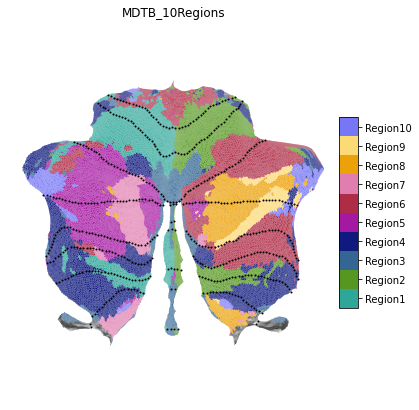

In [24]:
# plot parcellation - cerebellum
fpaths, cortex_names = nio.get_cerebellar_atlases()
@widgets.interact(parcellation=fpaths,
                 colorbar=[True, False],
                title=[True, False])

def plot_parcellation(parcellation, colorbar, title):
    view = vis.map_atlas(parcellation, structure='cerebellum', colorbar=colorbar, title=title)

interactive(children=(Dropdown(description='parcellation', options=('/Users/maedbhking/Documents/cerebellum_co…

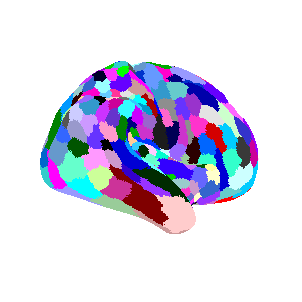

In [23]:
# plot parcellation - cortex

fpaths, cortex_names = nio.get_cortical_atlases()
@widgets.interact(parcellation=fpaths, 
                colorbar=[True, False],
                title=[False, True])

def plot_parcellation(parcellation, colorbar, title):
    view = vis.map_atlas(parcellation, structure='cortex', title=title)